In [50]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re
from wordcloud import WordCloud


In [51]:
data_path = r"../data/processed/all_data.csv"

In [52]:
# load data into dataframe
df = pd.read_csv(data_path)
df.reset_index()
df = df.drop(df.columns[0], axis=1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [53]:
display(df.head(7))
print("Total messages: ", len(df))
print("Total Characters: ", df['text'].str.len().sum())

,timedate,sender,text
0,"26.05.19, 13:14",Nachrichten und Anrufe sind Ende-zu-Ende-versc...,NaN
1,"26.05.19, 13:14",Nimrod W,Dan cookson can dew if
2,"26.05.19, 13:14",Nimrod W,It
3,"26.05.19, 13:15",Alex Friend,Gotcha
4,"26.05.19, 13:15",Alex Friend,Will deliver
5,"26.05.19, 13:15",Nimrod W,Amazing
6,"26.05.19, 13:15",Nimrod W,This will change my life


Total messages:  161823
Total Characters:  4447161.0


In [54]:
# let's have a little look at some of the stats
df[['sender','text']].groupby(['sender']).count().sort_values(by='text', ascending=False).head(18)

,text
sender,
Nimrod W,52894
Yoav Wynne,16134
Annika Guez,15833
Eytan Merkier,7434
Judy Peritz-Wynne (Mum),6719
Walt Trustam,6653
Scott Fielding,6498
Avishai Wynne,6034
Jonathan Wynne (Dad),4289


In [55]:
message_lengths = df['text'].str.len().to_list()
mean_len = np.mean(message_lengths)
print("Mean Message Length: ", np.round(mean_len))
print("Minumum and Maximum: ", np.min(message_lengths), ", ", np.max(message_lengths))
print("Median length: ", np.median(message_lengths))

Mean Message Length:  nan
Minumum and Maximum:  nan ,  nan
Median length:  nan


In [56]:
print(df.loc[df['text'].str.len() > 200])

               timedate                                             sender                                               text
2745    27.01.20, 12:37                                     Daniel Cordell   מה לעזאזל פשוט אמרת עלי, כלבה קטנה? אוודע לך ...
2942    23.12.20, 01:01                                      Eytan Merkier   Tangent which wasn't completed due to my drun...
2944    23.12.20, 01:07                                      Eytan Merkier   I think this is just my personality/ characte...
3672    06.03.21, 20:53                                           Nimrod W   I think the biggest reason I like the Mered F...
3689    07.03.21, 11:15                                           Nimrod W   she offered to make a list of points or even ...
4011    15.03.21, 14:54                                      Eytan Merkier   As in, has it ever happened that you haven't ...
4357    29.03.21, 23:16                                           Nimrod W   Yesterday afternoon ( during the Chag) I 

156450  14.12.22, 18:08                                           Nimrod W   שלום נמרוד.שוחחתי עם רוזלי. היא מתקיימת מדמי ...


Here we see the distribution of message lengths. Plotting using a log scale we can see a that most messages there are a small minority of very long messages

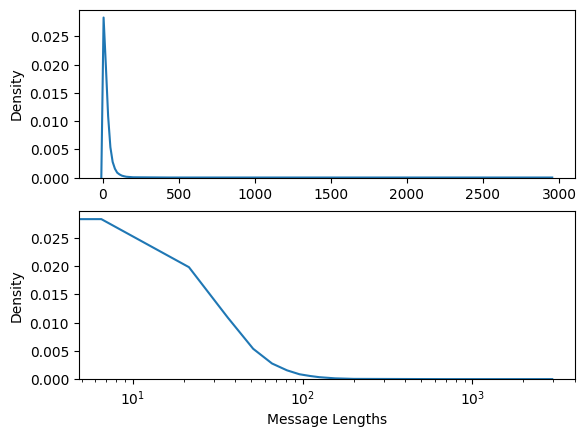

In [57]:
# let's have a look at the distributions of the message lengths
fig, ax = plt.subplots(2)
plt.xlabel("Message Lengths")
sns.kdeplot(message_lengths, ax=ax[0])
sns.kdeplot(message_lengths, ax=ax[1]) 
ax[1].set_xscale('log')
plt.show()

In [69]:
# let's have a look at the times that messages were sent at
# maybe hour of day vs number of messages?
# first, let's convert the datetime to a useable datetime object
def text_to_datetime(text):
    try:
        return datetime.strptime(text, "%d.%m.%y, %H:%M")
    except:
        return None
        
df_date = df.copy()
df_date['datetime'] = df_date.apply(lambda row: text_to_datetime(row['timedate']), axis=1)
display(df_date)

,timedate,sender,text,datetime
0,"26.05.19, 13:14",Nachrichten und Anrufe sind Ende-zu-Ende-versc...,NaN,2019-05-26 13:14:00
1,"26.05.19, 13:14",Nimrod W,Dan cookson can dew if,2019-05-26 13:14:00
2,"26.05.19, 13:14",Nimrod W,It,2019-05-26 13:14:00
3,"26.05.19, 13:15",Alex Friend,Gotcha,2019-05-26 13:15:00
4,"26.05.19, 13:15",Alex Friend,Will deliver,2019-05-26 13:15:00
...,...,...,...,...
161818,"16.01.23, 18:05",Nimrod W,strong af,2023-01-16 18:05:00
161819,"16.01.23, 19:11",Inbar Hasson,Yeah,2023-01-16 19:11:00
161820,"16.01.23, 19:11",Inbar Hasson,But isn't he a bitch or somtn?,2023-01-16 19:11:00
161821,"16.01.23, 20:23",Nimrod W,yes,2023-01-16 20:23:00


<AxesSubplot: xlabel='datetime'>

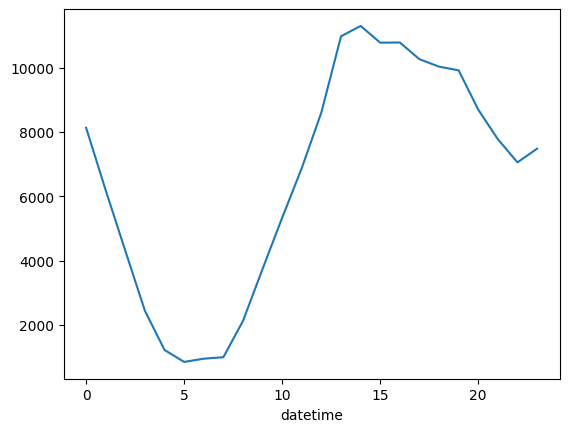

In [59]:
# here we have a plot of hour of the day versus number of messages sent. 
df_date.groupby(df_date['datetime'].dt.hour).count()['text'].plot()

In [60]:
# let's now look at the unique words in the data frame
unique = list(df['text'].str.split(" ", expand=True).stack().unique())

In [61]:
unique_word_counts = df['text'].str.split(' ', expand=True).stack().value_counts()

In [62]:
top_words = unique_word_counts.index.tolist()
print("No. Unique words: ", len(unique))

No. Unique words:  70813


In [63]:
wordcloud_all_senders = WordCloud(width=800, height=800,
                                    background_color ='white', stopwords=None,
                                    min_font_size=10, min_word_length=3).generate(' '.join(top_words[:500]))

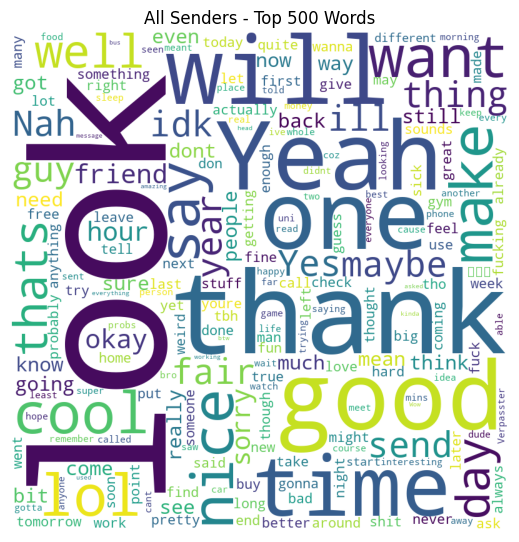

In [64]:
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud_all_senders)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("All Senders - Top 500 Words")
 
plt.show()

In [76]:
def create_word_cloud(sender, top_n_words=200):
    font_path = r"C:\Windows\Fonts\Arial.ttf"
    unique_words = df['text'].loc[df['sender'] == sender].str.split(" ", expand=True).stack().value_counts()
    words = unique_words.index.tolist()[1::]
    freqs = unique_words.tolist()[1::]
    d = dict(zip(words, freqs))
    wordcloud = WordCloud(width=800, height=800,
                          font_path=font_path,
                          background_color ='white', stopwords=None,
                          min_font_size=10, min_word_length=3).generate(' '.join(words[:top_n_words]))
#    .generate_from_frequencies(d)
    return wordcloud

In [77]:
top_senders = df[['sender','text']].groupby(['sender']).count().sort_values(by='text', ascending=False)
top_senders = top_senders.index.tolist()[:10]

In [78]:
# plot subplots of top senders: 
wordclouds = []
n_words = 500
for i, sender in enumerate(top_senders):
    wc = create_word_cloud(sender, n_words)
    wordclouds.append(wc)

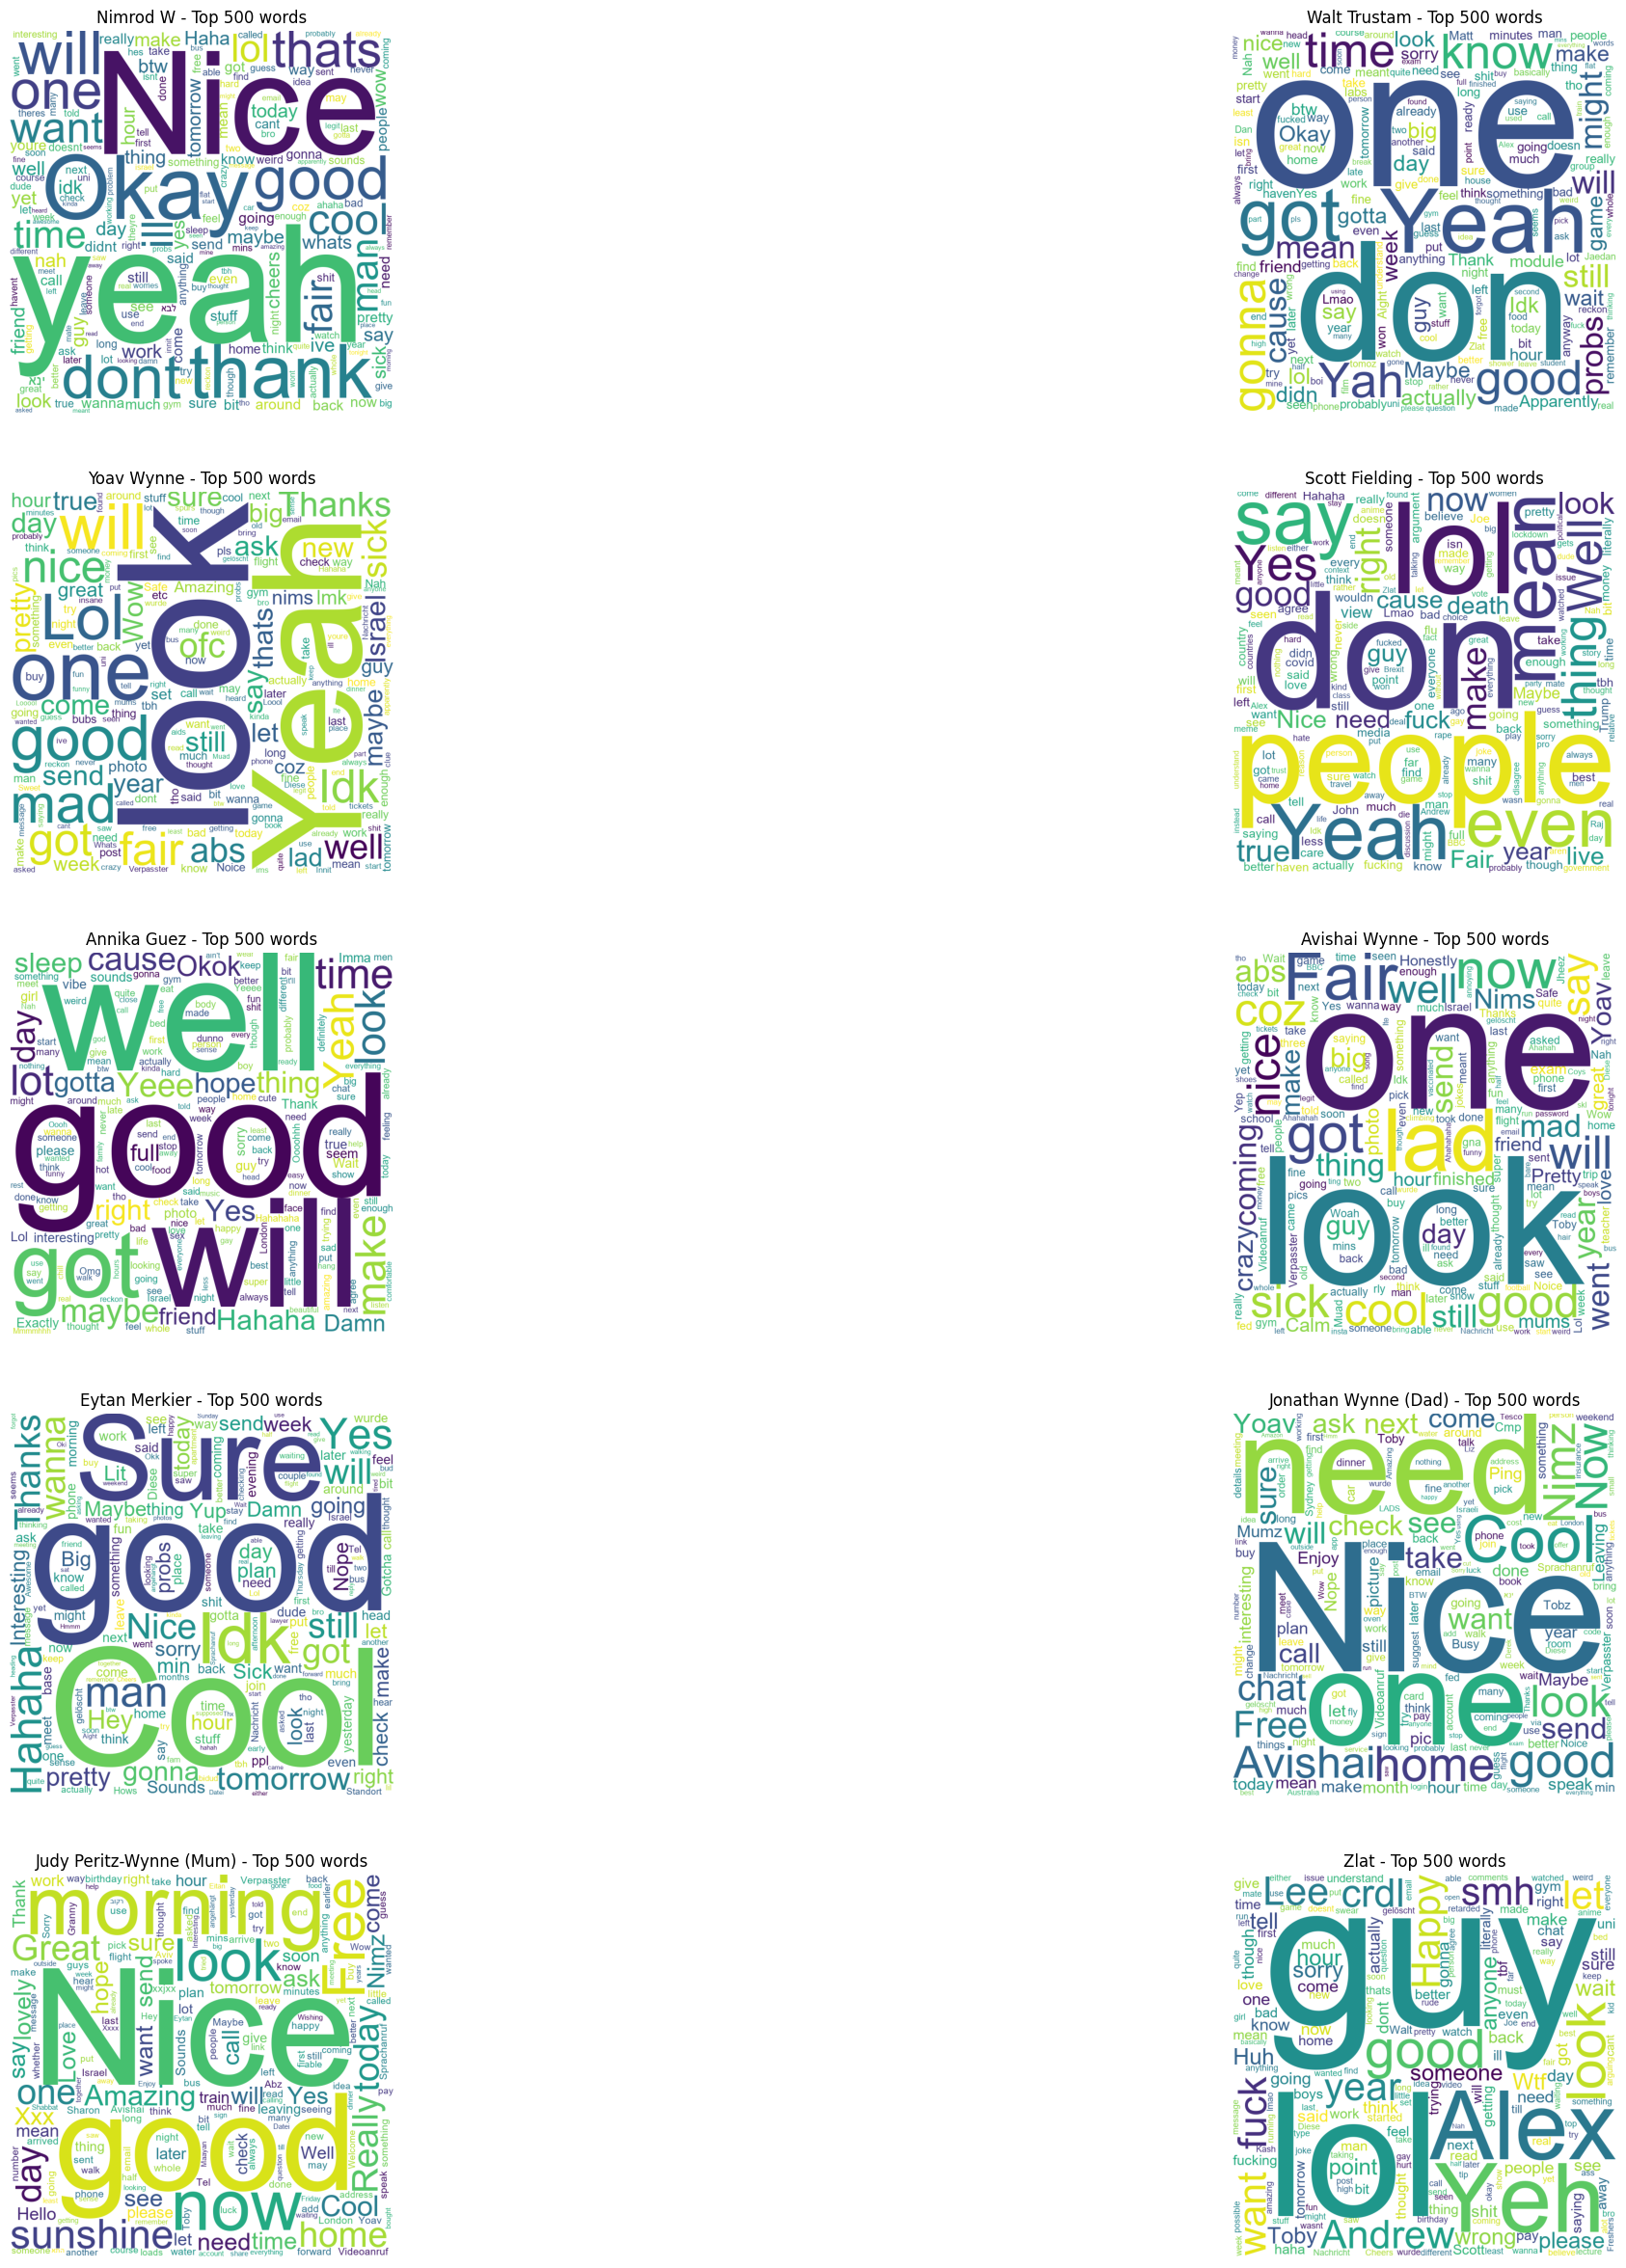

In [79]:
fig, ax = plt.subplots(int(len(top_senders)/2), 2, figsize=(30, 30))
# fig, ax = plt.subplots(int(len(top_senders)), figsize=(30, 30))
k = 0
for i in range(2):
    for j in range(int(len(top_senders)/2)):
        ax[j, i].imshow(wordclouds[k])
        ax[j, i].set_title(top_senders[k] + " - Top " + str(n_words) + " words")
        ax[j, i].axis("off")
        k += 1
plt.show()